# Kaggle Flight Delays

- URL: https://www.kaggle.com/competitions/flight-delays-spring-2018/
- Students: rjhxa@cesar.school e gsg@cesar.school

In [425]:
# General Imports
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier, Pool

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Images
from IPython.display import Image

## Functions

In [287]:
def get_origin_csv():
    x = pd.read_csv('raw_data/flight_delays_train.csv')
    y = pd.read_csv('raw_data/flight_delays_test.csv')

    return x, y

In [288]:
def convert_period(hour):
    aux = ''
    if hour >= 6 and hour < 12:
        aux = 'morning'
    elif hour >= 12 and hour < 18:
        aux = 'afternoon'
    elif hour >= 18 and hour < 24:
        aux = 'night'
    else:
        aux = 'dawn'

    return aux

In [289]:
def transform_df(df):
    df['Month'] = df['Month'].str[2:].astype('int')
    df['DayofMonth'] = df['DayofMonth'].str[2:].astype('int')
    df['DayOfWeek'] = df['DayOfWeek'].str[2:].astype('int')
    df['DepTime_hour'] = df['DepTime']//100
    df['DepTime_minute'] =  df['DepTime']%100
    df['Time_period'] = df['DepTime_hour'].apply(convert_period)

    return df

In [409]:
def feature_updating(df):
    df['Route'] =  df['Origin'] + "_" + df['Dest']
    df['Route_TimePeriod'] = df['Route'] + '_' + df['Time_period']
    df['Route_DayWeek'] = df['Route'] + '_' + df['DayOfWeek'].astype('str')

    df['Carrier_Origin'] = df['UniqueCarrier'] + "_" + df['Origin']
    df['Carrier_Dest'] = df['UniqueCarrier'] + "_" + df['Dest']
    df['Carrier_DepHour'] = df['UniqueCarrier'] + '_' + df['DepTime_hour'].astype('str')

    df['Origin_TimePeriod'] = df['Origin'] + '_' + df['Time_period']

    return df
    

In [291]:
def prepare_df(train, test, cols):
    x_train = train.drop(cols, axis=1)
    cols.remove('dep_delayed_15min')
    x_test = test.drop(cols, axis=1)

    return x_train, x_test

## Exploraty Data Analysis (EDA)

In [396]:
train, test = get_origin_csv()

In [390]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [391]:
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258
...,...,...,...,...,...,...,...,...
99995,c-6,c-5,c-2,852,WN,CRP,HOU,187
99996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
99997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
99998,c-1,c-5,c-5,804,DL,LGA,ATL,761


In [295]:
train.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min'],
      dtype='object')

In [296]:
test.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance'],
      dtype='object')

In [297]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [298]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [299]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [300]:
test.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1338.936600,723.13011
std,480.554102,563.22322
min,1.000000,31.00000
25%,928.000000,321.00000
50%,1329.000000,574.00000
75%,1733.000000,948.00000
max,2400.000000,4962.00000


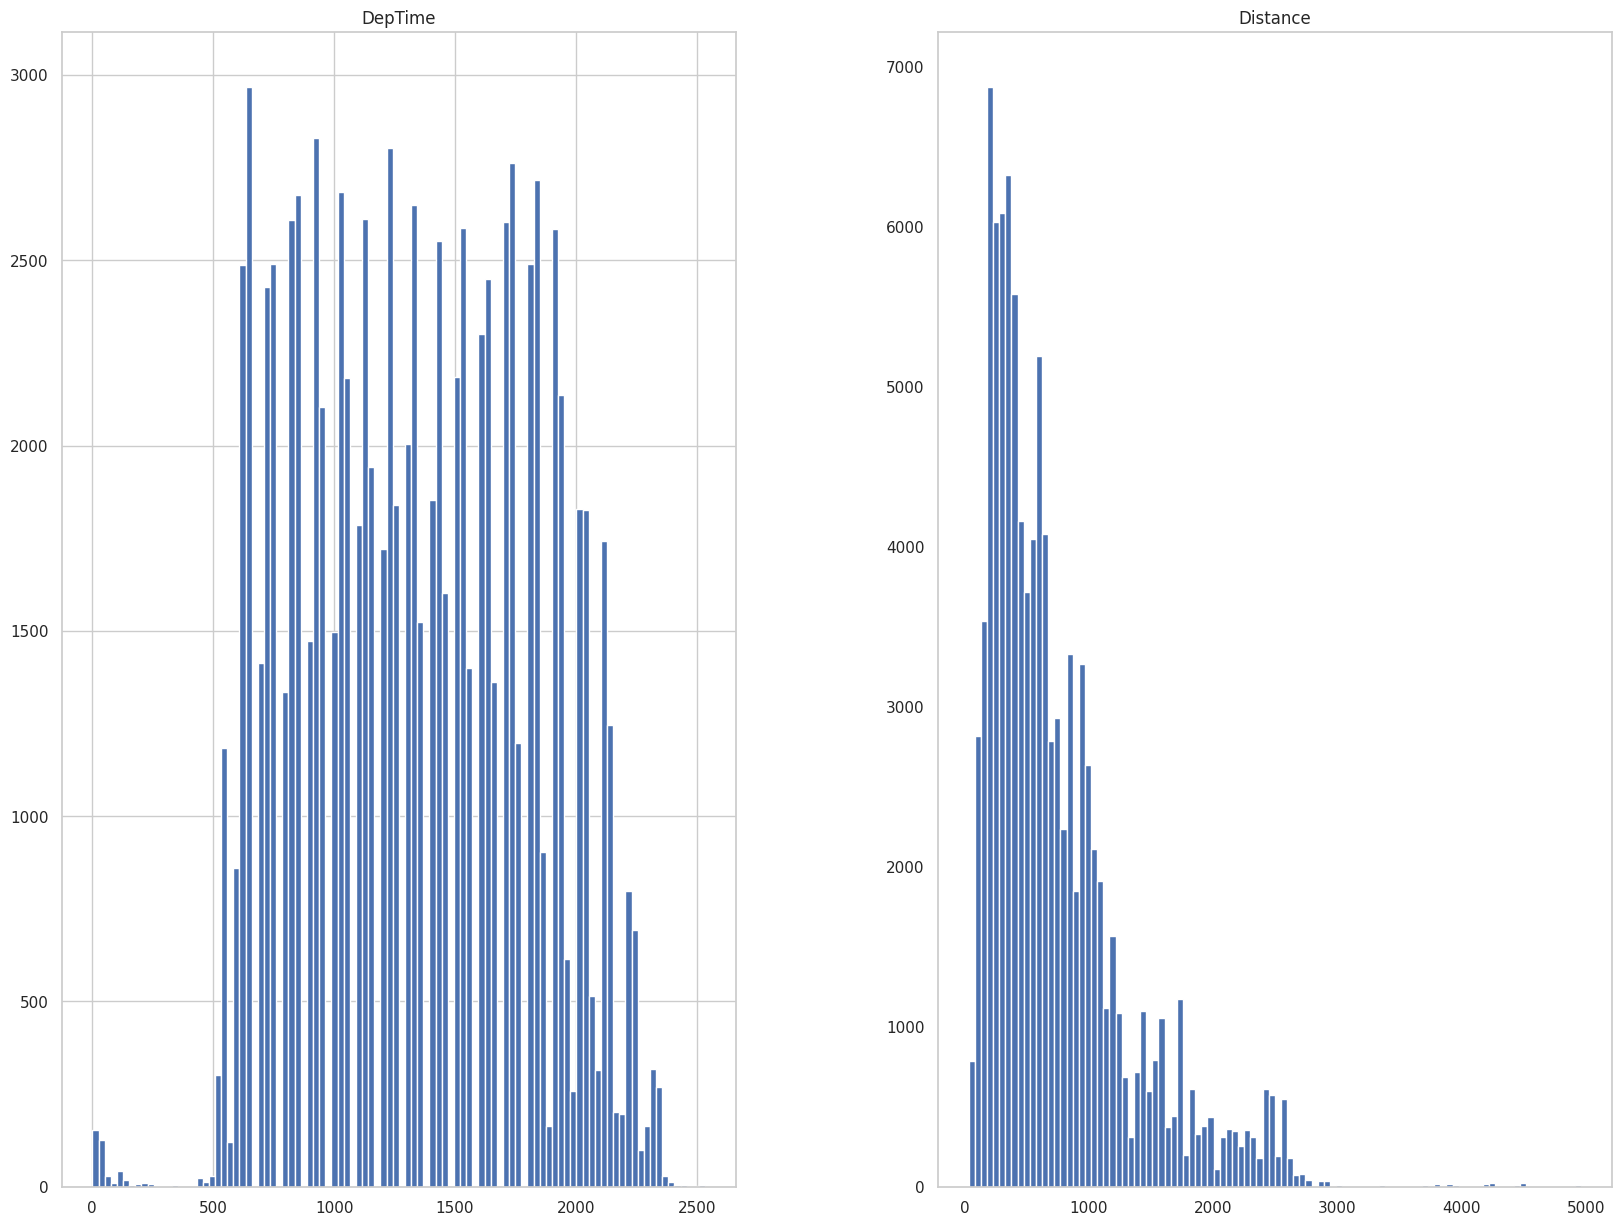

In [301]:
train.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

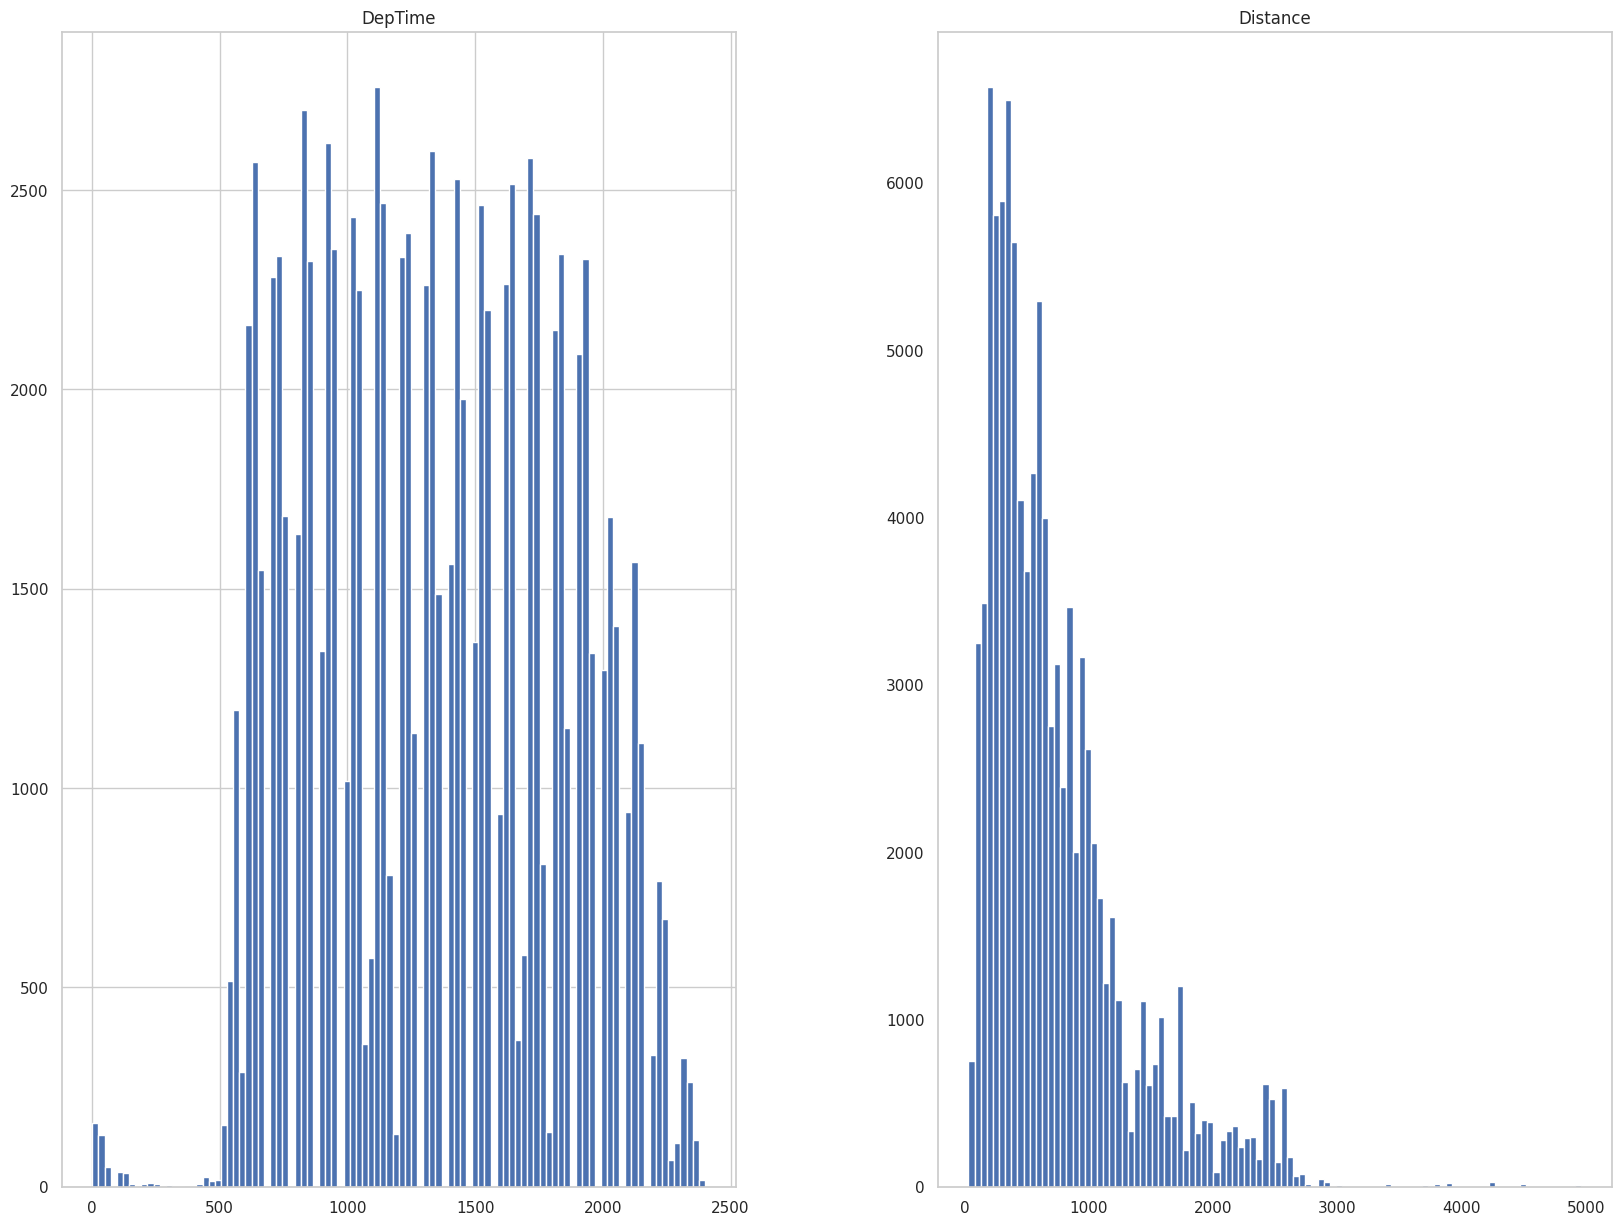

In [302]:
test.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

## Data Processing

- Transforming columns to make better use of features and creating new ones to increase catboot performance

In [303]:
pd.set_option('future.no_silent_downcasting', True)

### Feature Engineering

In [397]:
train['dep_delayed_15min'] = train['dep_delayed_15min'].replace({'N': 0, 'Y': 1})
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,0
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,0
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,0
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,0


In [398]:
train = transform_df(train)
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_hour,DepTime_minute,Time_period
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34,night
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,afternoon
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,afternoon
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15,morning
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,night
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,18,afternoon
99996,1,18,3,804,CO,EWR,DAB,884,0,8,4,morning
99997,1,24,2,1901,NW,DTW,IAH,1076,0,19,1,night
99998,4,27,4,1515,MQ,DFW,GGG,140,0,15,15,afternoon


In [399]:
test = transform_df(test)
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,DepTime_hour,DepTime_minute,Time_period
0,7,25,3,615,YV,MRY,PHX,598,6,15,morning
1,4,17,2,739,WN,LAS,HOU,1235,7,39,morning
2,12,2,7,651,MQ,GSP,ORD,577,6,51,morning
3,3,25,7,1614,WN,BWI,MHT,377,16,14,afternoon
4,6,6,3,1505,UA,ORD,STL,258,15,5,afternoon
...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,8,52,morning
99996,11,24,6,1446,UA,ORD,LAS,1515,14,46,afternoon
99997,1,30,2,1509,OO,ORD,SGF,438,15,9,afternoon
99998,1,5,5,804,DL,LGA,ATL,761,8,4,morning


In [400]:
train = feature_updating(train)
test = feature_updating(test)

In [401]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_hour,DepTime_minute,Time_period,Route,Route_TimePeriod,Route_DayWeek,Carrier_Origin,Carrier_Dest,Carrier_DepHour,Origin_TimePeriod
0,8,21,7,1934,AA,ATL,DFW,732,0,19,34,night,ATL_DFW,ATL_DFW_night,ATL_DFW_7,AA_ATL,AA_DFW,AA_19,ATL_night
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,afternoon,PIT_MCO,PIT_MCO_afternoon,PIT_MCO_3,US_PIT,US_MCO,US_15,PIT_afternoon
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,afternoon,RDU_CLE,RDU_CLE_afternoon,RDU_CLE_5,XE_RDU,XE_CLE,XE_14,RDU_afternoon
3,11,25,6,1015,OO,DEN,MEM,872,0,10,15,morning,DEN_MEM,DEN_MEM_morning,DEN_MEM_6,OO_DEN,OO_MEM,OO_10,DEN_morning
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,night,MDW_OMA,MDW_OMA_night,MDW_OMA_6,WN_MDW,WN_OMA,WN_18,MDW_night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,18,afternoon,SFO_RDD,SFO_RDD_afternoon,SFO_RDD_3,OO_SFO,OO_RDD,OO_16,SFO_afternoon
99996,1,18,3,804,CO,EWR,DAB,884,0,8,4,morning,EWR_DAB,EWR_DAB_morning,EWR_DAB_3,CO_EWR,CO_DAB,CO_8,EWR_morning
99997,1,24,2,1901,NW,DTW,IAH,1076,0,19,1,night,DTW_IAH,DTW_IAH_night,DTW_IAH_2,NW_DTW,NW_IAH,NW_19,DTW_night
99998,4,27,4,1515,MQ,DFW,GGG,140,0,15,15,afternoon,DFW_GGG,DFW_GGG_afternoon,DFW_GGG_4,MQ_DFW,MQ_GGG,MQ_15,DFW_afternoon


In [402]:
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,DepTime_hour,DepTime_minute,Time_period,Route,Route_TimePeriod,Route_DayWeek,Carrier_Origin,Carrier_Dest,Carrier_DepHour,Origin_TimePeriod
0,7,25,3,615,YV,MRY,PHX,598,6,15,morning,MRY_PHX,MRY_PHX_morning,MRY_PHX_3,YV_MRY,YV_PHX,YV_6,MRY_morning
1,4,17,2,739,WN,LAS,HOU,1235,7,39,morning,LAS_HOU,LAS_HOU_morning,LAS_HOU_2,WN_LAS,WN_HOU,WN_7,LAS_morning
2,12,2,7,651,MQ,GSP,ORD,577,6,51,morning,GSP_ORD,GSP_ORD_morning,GSP_ORD_7,MQ_GSP,MQ_ORD,MQ_6,GSP_morning
3,3,25,7,1614,WN,BWI,MHT,377,16,14,afternoon,BWI_MHT,BWI_MHT_afternoon,BWI_MHT_7,WN_BWI,WN_MHT,WN_16,BWI_afternoon
4,6,6,3,1505,UA,ORD,STL,258,15,5,afternoon,ORD_STL,ORD_STL_afternoon,ORD_STL_3,UA_ORD,UA_STL,UA_15,ORD_afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,8,52,morning,CRP_HOU,CRP_HOU_morning,CRP_HOU_2,WN_CRP,WN_HOU,WN_8,CRP_morning
99996,11,24,6,1446,UA,ORD,LAS,1515,14,46,afternoon,ORD_LAS,ORD_LAS_afternoon,ORD_LAS_6,UA_ORD,UA_LAS,UA_14,ORD_afternoon
99997,1,30,2,1509,OO,ORD,SGF,438,15,9,afternoon,ORD_SGF,ORD_SGF_afternoon,ORD_SGF_2,OO_ORD,OO_SGF,OO_15,ORD_afternoon
99998,1,5,5,804,DL,LGA,ATL,761,8,4,morning,LGA_ATL,LGA_ATL_morning,LGA_ATL_5,DL_LGA,DL_ATL,DL_8,LGA_morning


### Some Plots After Processing

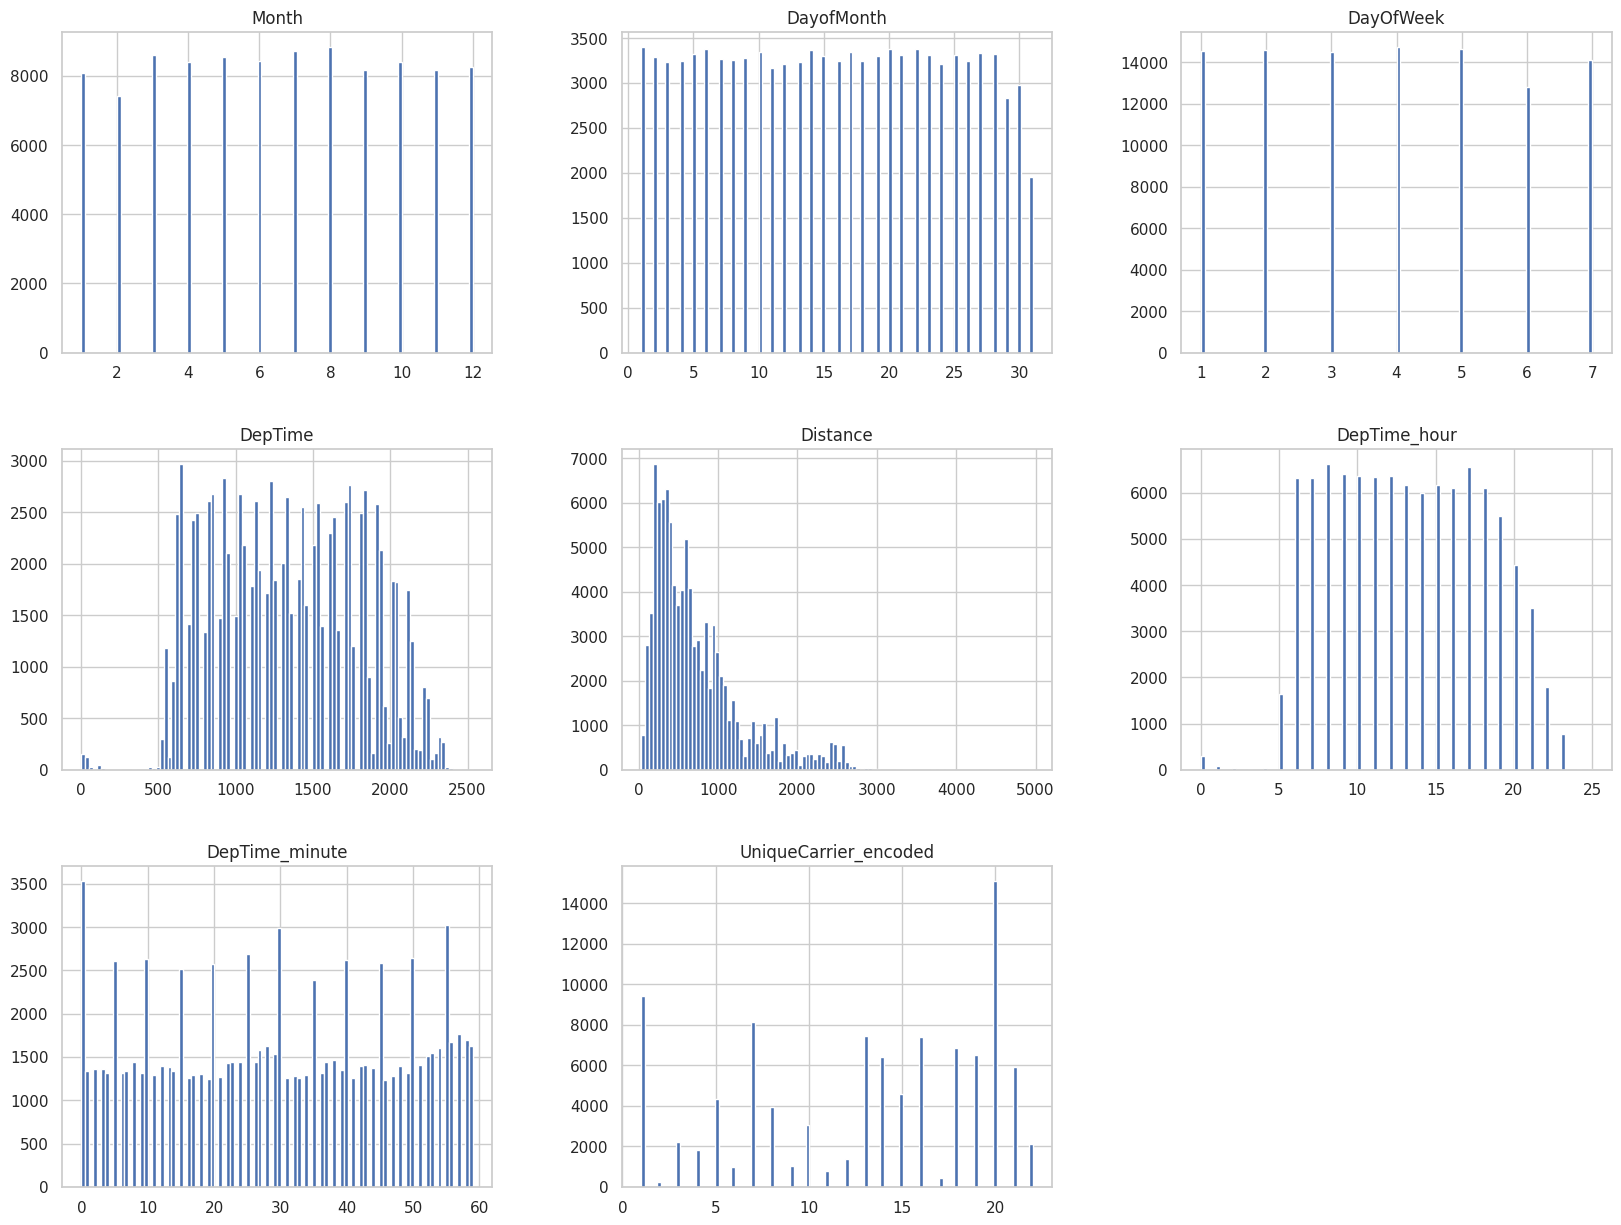

In [314]:
train.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

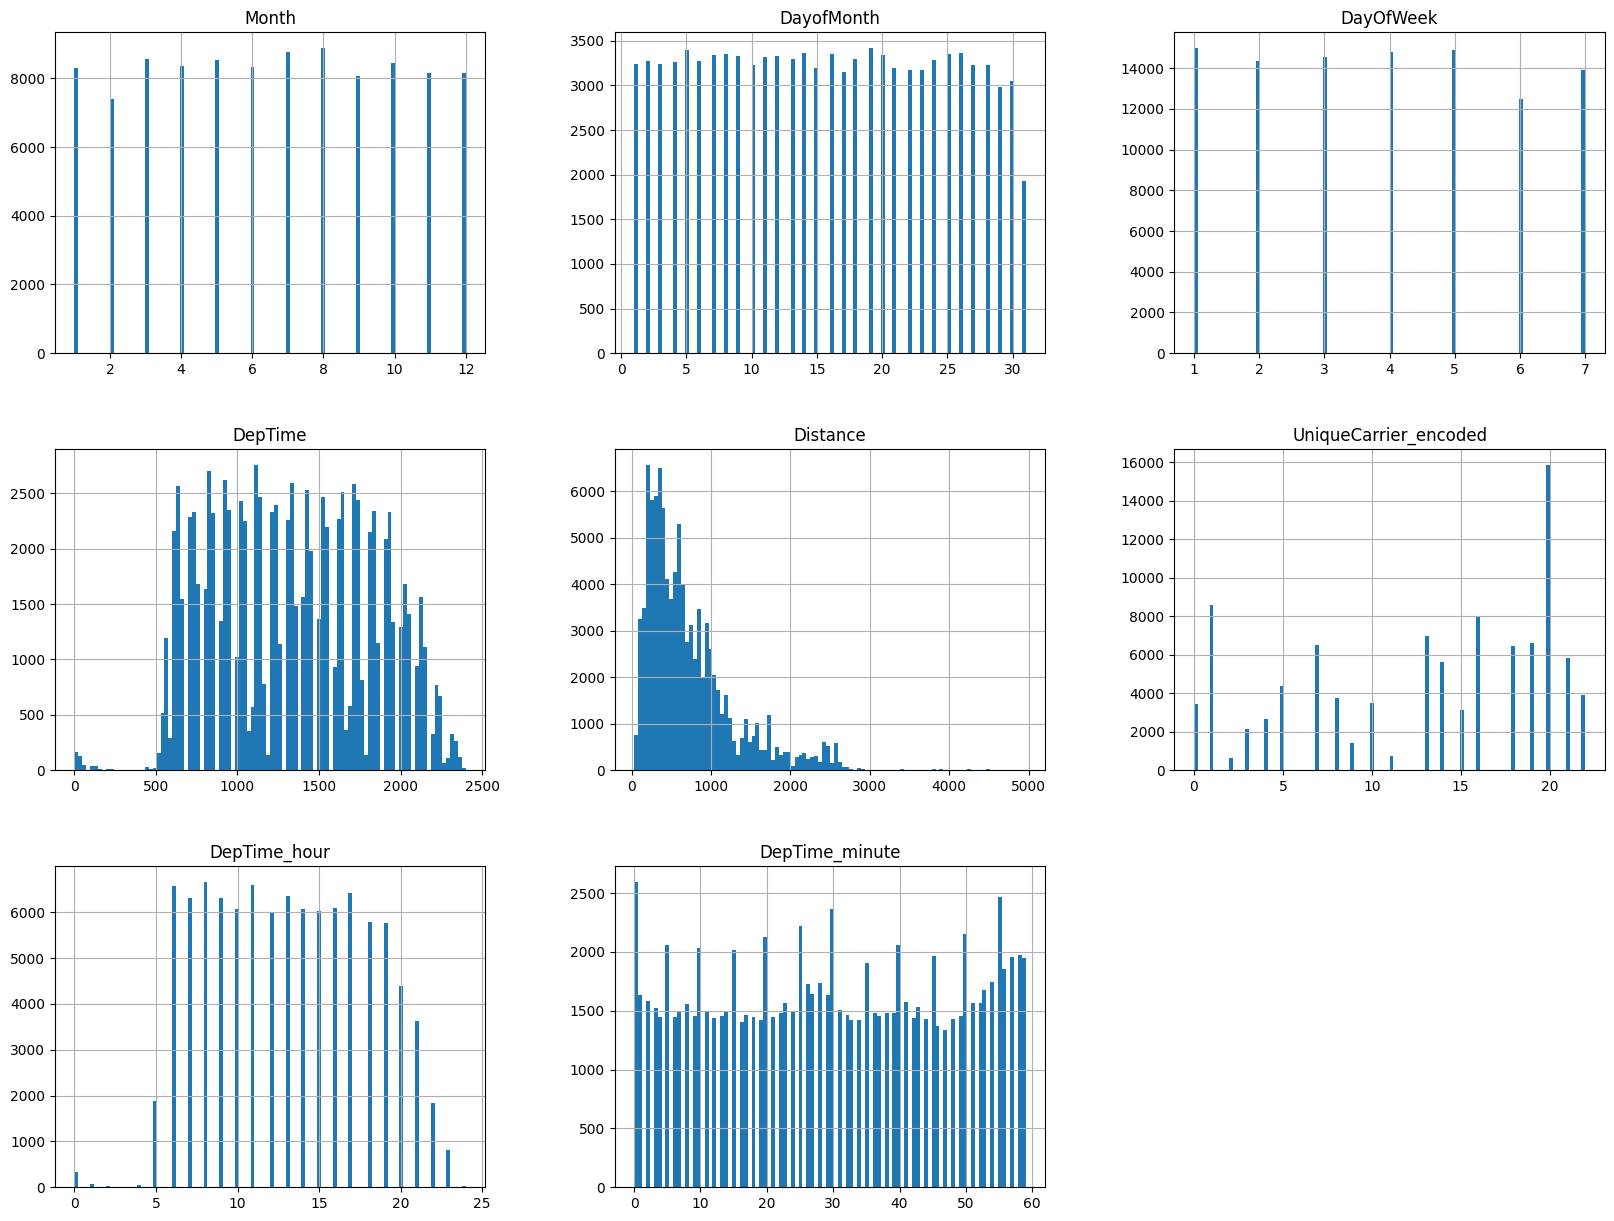

In [121]:
test.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

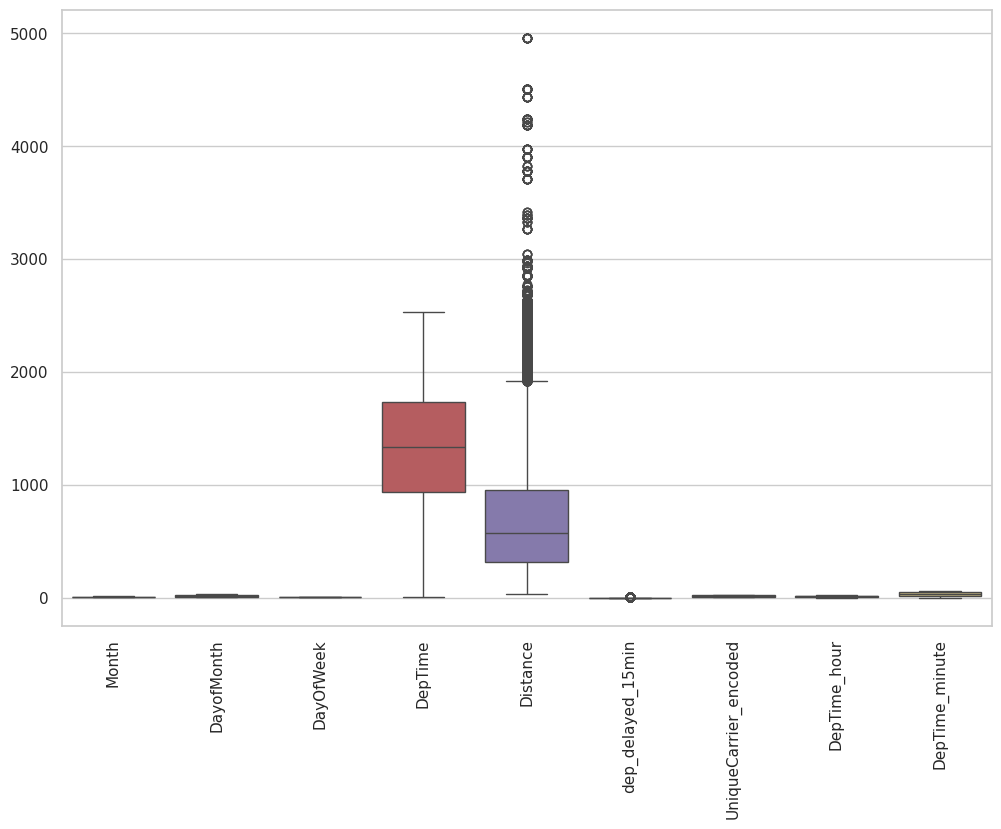

In [126]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show()

## Experiments

In [30]:
y = train['dep_delayed_15min'].copy()
y

0        0
1        0
2        0
3        0
4        1
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: dep_delayed_15min, Length: 100000, dtype: object

In [47]:
y = y.astype(int)

### CatBoost

- I chose CatBoost for this model due to its ability to handle categorical features effectively without the need for extensive preprocessing. CatBoost implements an efficient gradient boosting algorithm that automatically handles categorical variables, providing robust performance without sacrificing computational efficiency. Additionally, CatBoost incorporates advanced techniques such as ordered boosting and oblivious trees, which further enhance its predictive power. Its built-in support for early stopping and cross-validation simplifies the model tuning process, allowing for quicker experimentation and optimization. 

#### HOLDOUT 80/20

In [403]:
cols = ['dep_delayed_15min']
X, X_test = prepare_df(train, test, cols)

In [404]:
X.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'DepTime_hour', 'DepTime_minute',
       'Time_period', 'Route', 'Route_TimePeriod', 'Route_DayWeek',
       'Carrier_Origin', 'Carrier_Dest', 'Carrier_DepHour',
       'Origin_TimePeriod'],
      dtype='object')

In [405]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state=33)

In [406]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'DepTime_hour', 'DepTime_minute',
       'Time_period', 'Route', 'Route_TimePeriod', 'Route_DayWeek',
       'Carrier_Origin', 'Carrier_Dest', 'Carrier_DepHour',
       'Origin_TimePeriod']

In [407]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=True)
val_pred = cb_model.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_pred)
print(f'ROC AUC Score (validation set): {val_roc_auc}')

Learning rate set to 0.093535
0:	test: 0.6907150	best: 0.6907150 (0)	total: 146ms	remaining: 2m 25s
1:	test: 0.7061898	best: 0.7061898 (1)	total: 275ms	remaining: 2m 17s
2:	test: 0.7094297	best: 0.7094297 (2)	total: 367ms	remaining: 2m 2s
3:	test: 0.7091750	best: 0.7094297 (2)	total: 571ms	remaining: 2m 22s
4:	test: 0.7104125	best: 0.7104125 (4)	total: 742ms	remaining: 2m 27s
5:	test: 0.7098869	best: 0.7104125 (4)	total: 857ms	remaining: 2m 22s
6:	test: 0.7097871	best: 0.7104125 (4)	total: 1.07s	remaining: 2m 32s
7:	test: 0.7119043	best: 0.7119043 (7)	total: 1.29s	remaining: 2m 40s
8:	test: 0.7142653	best: 0.7142653 (8)	total: 1.44s	remaining: 2m 38s
9:	test: 0.7177650	best: 0.7177650 (9)	total: 1.57s	remaining: 2m 36s
10:	test: 0.7221847	best: 0.7221847 (10)	total: 1.73s	remaining: 2m 35s
11:	test: 0.7233766	best: 0.7233766 (11)	total: 1.91s	remaining: 2m 37s
12:	test: 0.7299478	best: 0.7299478 (12)	total: 2.12s	remaining: 2m 40s
13:	test: 0.7304559	best: 0.7304559 (13)	total: 2.29s	r

##### ROC Curve

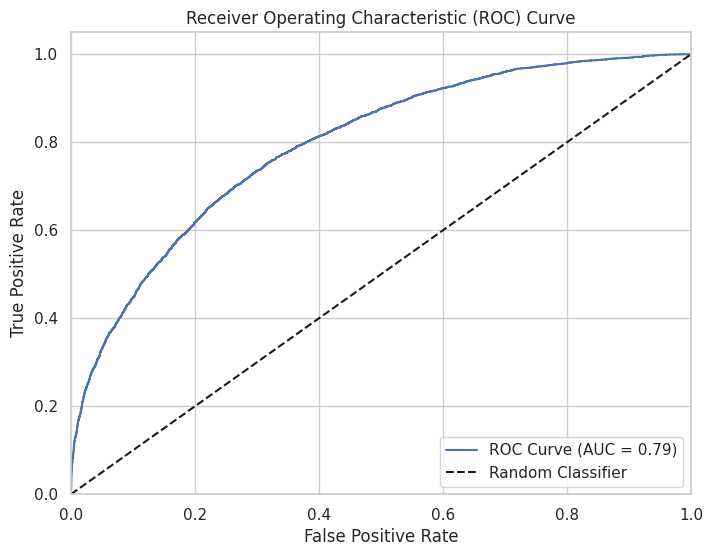

In [411]:
fpr, tpr, thresholds = roc_curve(y_val, val_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### Tree Plot

- The Tree plot wasn't satisfactory because it's to extensive!

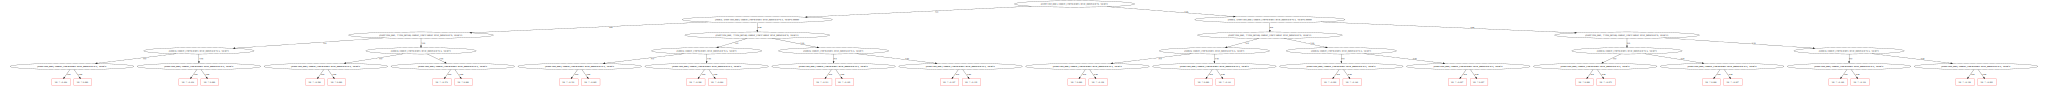

In [421]:
cb_model.plot_tree(tree_idx=0, pool=Pool(X_val, y_val, cat_features=cat_features))

##### X_test Predict

In [422]:
pred = cb_model.predict_proba(X_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg.csv', index_label='id', header=True)

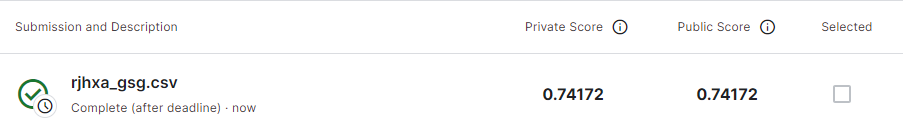

In [431]:
Image('./images/holdout.png')

#### NO HOLDOUT

In [427]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'DepTime_hour', 'DepTime_minute',
       'Time_period', 'Route', 'Route_TimePeriod', 'Route_DayWeek',
       'Carrier_Origin', 'Carrier_Dest', 'Carrier_DepHour',
       'Origin_TimePeriod']

In [428]:
cb_model_ = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model_.fit(X, y, cat_features=cat_features, use_best_model=True, verbose=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.07361
0:	total: 162ms	remaining: 2m 42s
1:	total: 392ms	remaining: 3m 15s
2:	total: 668ms	remaining: 3m 42s
3:	total: 953ms	remaining: 3m 57s
4:	total: 1.03s	remaining: 3m 25s
5:	total: 1.29s	remaining: 3m 33s
6:	total: 1.4s	remaining: 3m 18s
7:	total: 1.57s	remaining: 3m 14s
8:	total: 1.71s	remaining: 3m 8s
9:	total: 1.9s	remaining: 3m 8s
10:	total: 2.08s	remaining: 3m 6s
11:	total: 2.25s	remaining: 3m 4s
12:	total: 2.4s	remaining: 3m 2s
13:	total: 2.61s	remaining: 3m 3s
14:	total: 2.77s	remaining: 3m 2s
15:	total: 2.97s	remaining: 3m 2s
16:	total: 3.23s	remaining: 3m 6s
17:	total: 3.49s	remaining: 3m 10s
18:	total: 3.75s	remaining: 3m 13s
19:	total: 4s	remaining: 3m 15s
20:	total: 4.27s	remaining: 3m 19s
21:	total: 4.49s	remaining: 3m 19s
22:	total: 4.72s	remaining: 3m 20s
23:	total: 4.93s	remaining: 3m 20s
24:	total: 5.12s	remaining: 3m 19s
25:	total: 5.42s	remaining: 3m 23s
26:	total: 5.66s	remaining: 3m 23s
27:	total: 6.01s	remaining: 3m 28s
28:	total: 6.26s

In [429]:
pred_ = cb_model_.predict_proba(X_test)[:,1]
pd.Series(pred_, name='dep_delayed_15min').to_csv('rjhxa_gsg_2.csv', index_label='id', header=True)

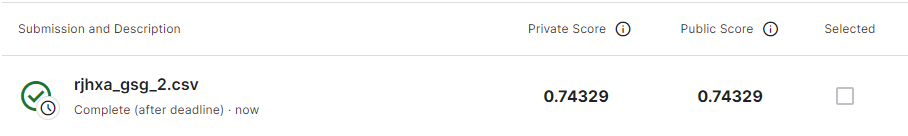

In [432]:
Image('./images/no_holdout.png')

## Conclusion

After analyzing the results of the experiments, we observed that the holdout method tends to yield higher performance scores compared to the train-test approach. This discrepancy raises the suspicion that the model may be suffering from overfitting, especially when exposed to a larger number of features.

To enhance the model, we can consider several approaches:

1. In-depth EDA exploration: Conducting a more detailed exploratory data analysis can help us identify more relevant features for the model. This may include identifying correlations between variables, detecting outliers, and gaining a deeper understanding of the relationship between features and the target.

2. Checking the overfitting theory: It is crucial to investigate whether the suspicion of overfitting is valid. This may involve evaluating the model's performance on separate training, validation, and test datasets, as well as techniques such as learning curves and cross-validation.

3. Conducting more tests: Expanding tests with the model in different configurations can provide additional insights into its behavior and performance. This may include experimenting with different learning algorithms, hyperparameter tuning, and data preprocessing techniques.

4. Feature engineering: Exploring advanced feature engineering techniques can help create more informative data representations, thereby improving the model's ability to capture complex and relevant patterns.

5. Regularization: Applying regularization techniques, such as L1/L2 regularization on the model's coefficients, can help mitigate overfitting by restricting the model's complexity.

6. Ensemble methods: Experimenting with ensemble methods, such as bagging, boosting, or stacking, can help improve the model's generalization by combining predictions from multiple base models.